# Solving the N-Body Problem

In [176]:
import torch
from src import hamiltonian, State, StateList
from src.utils import plot_trajectory
from PIL import Image, ImageDraw
import imageio

## Defining the Hamiltonian

In [2]:
@hamiltonian
def n_body_hamiltonian(q, p, t, m, G):
    T = (p**2).sum(2) / (2 * m)
    r = torch.cdist(q, q)
    U = -1 * G * (m.unsqueeze(0).transpose(0, 1) @ m.unsqueeze(0)) / r
    U[U == float('-inf')] = 0
    return T.sum(1) + 0.5 * U.sum((1, 2))

## The 2-Body Problem

In [3]:
m = torch.tensor([5.0, 1.0])
G = torch.tensor(1.0)
time_step = 0.00075
num_steps = 25000

In [4]:
initial_state = State(q=torch.tensor([[-1.0, 0.0], [1.0, 0.0]]),
                      p=torch.tensor([[0.0, -1.0], [0.0, 1.0]]),
                      t=torch.tensor(0.0))
empty_trajectory = StateList(q=torch.empty(num_steps, *initial_state.q.shape),
                             p=torch.empty(num_steps, *initial_state.q.shape),
                             t=torch.empty(num_steps))

In [5]:
state = initial_state.copy()
trajectory = empty_trajectory.copy()

In [6]:
for index in range(num_steps):
    trajectory[index] = state
    H = n_body_hamiltonian(state, m=m, G=G)
    H.backward()
    state = state.step(time_step)

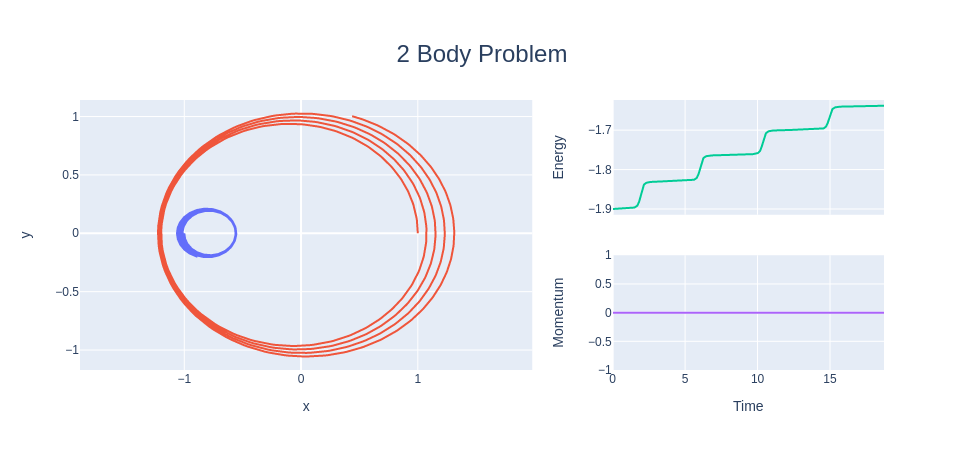

In [7]:
fig = plot_trajectory(trajectory, n_body_hamiltonian, m=m, G=G, name='2 Body Problem')
fig.show()

### Correction: Conserve Energy

In [8]:
state = initial_state.copy()
trajectory = empty_trajectory.copy()
H0 = n_body_hamiltonian(state, m=m, G=G).item()

In [9]:
for index in range(num_steps):
    trajectory[index] = state
    H = n_body_hamiltonian(state, m=m, G=G)
    H.backward()
    state = state.step(time_step, d=(H0 - H.item()))

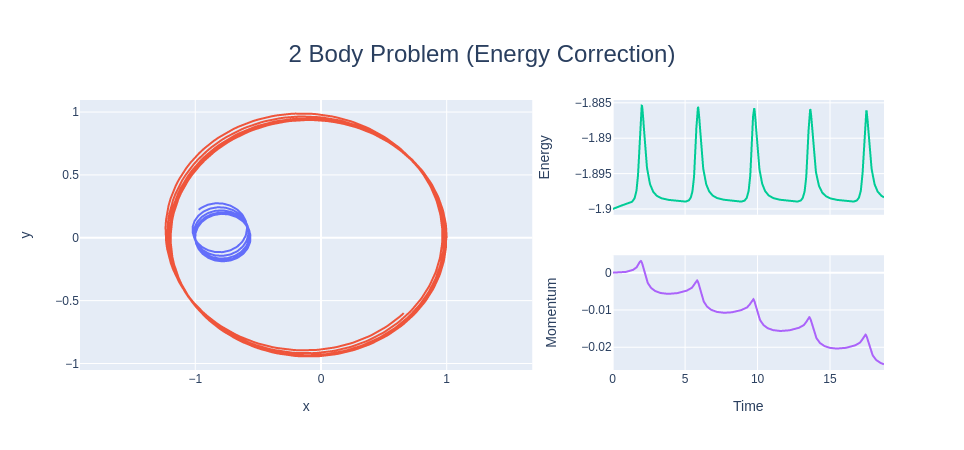

In [10]:
fig = plot_trajectory(trajectory, n_body_hamiltonian, m=m, G=G,
                      name='2 Body Problem (Energy Correction)')
fig.show()

### Correction: Conserve Energy and Momentum

In [11]:
state = initial_state.copy()
trajectory = empty_trajectory.copy()
H0 = n_body_hamiltonian(state, m=m, G=G).item()

In [12]:
for index in range(num_steps):
    trajectory[index] = state
    H = n_body_hamiltonian(state, m=m, G=G)
    H.backward()
    dp_dt = state.dp_dt(d=(H0 - H.item()))
    dp_dt = dp_dt - dp_dt.mean(0)
    state = state.step(time_step, dp_dt=dp_dt)

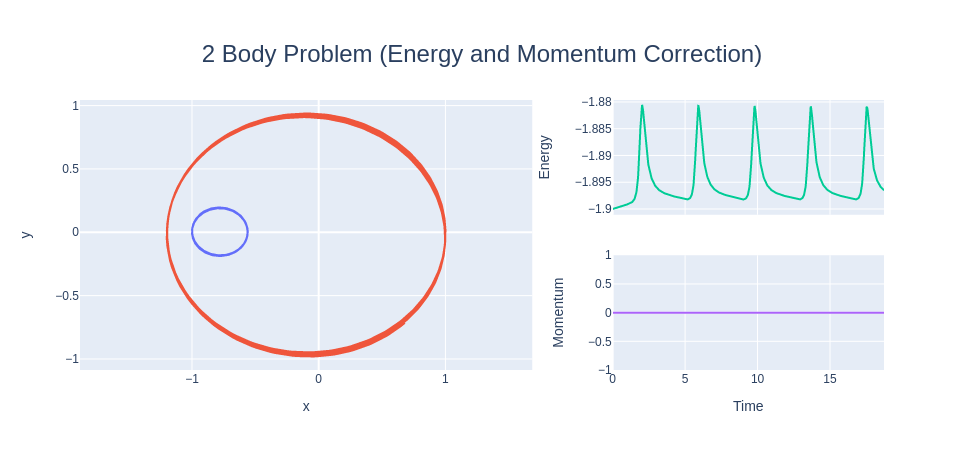

In [13]:
fig = plot_trajectory(trajectory, n_body_hamiltonian, m=m, G=G,
                      name='2 Body Problem (Energy and Momentum Correction)')
fig.show()

## The 3-Body Problem

In [14]:
m = torch.tensor([1, 2.5, 5])
G = torch.tensor(1)
time_step = .001
num_steps = 50000
state = State(q=torch.tensor([[0.5, 2.0], [1.5, -1.5], [-1.5, -1.5]]),
              p=torch.tensor([[0.5, -1.0], [-1.0, -0.5], [0.5, 1.5]]),
              t=torch.tensor(0.0))
trajectory = StateList(q=torch.empty(num_steps, *state.q.shape),
                       p=torch.empty(num_steps, *state.q.shape),
                       t=torch.empty(num_steps))
H0 = n_body_hamiltonian(state, m=m, G=G).item()

In [16]:
for index in range(num_steps):
    trajectory[index] = state
    H = n_body_hamiltonian(state, m=m, G=G)
    H.backward()
    dp_dt = state.dp_dt(d=(H0 - H.item()))
    dp_dt = dp_dt - dp_dt.mean(0)
    state = state.step(time_step, dp_dt=dp_dt)

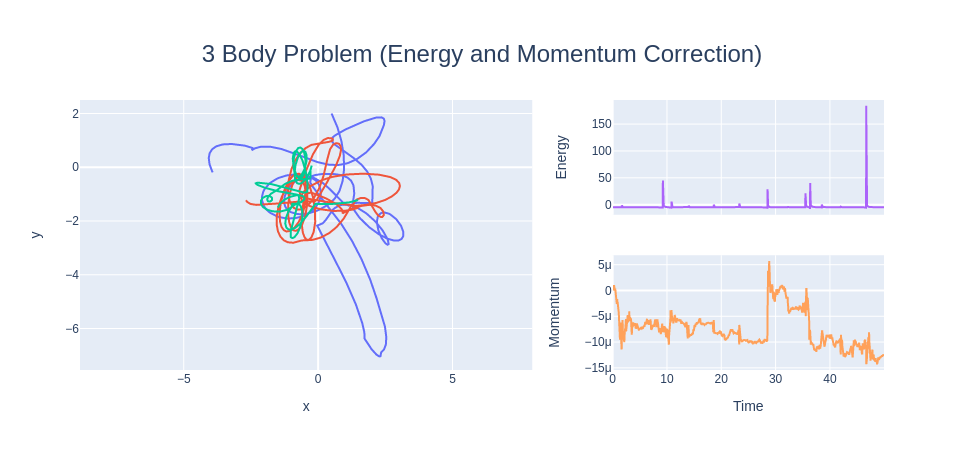

In [17]:
fig = plot_trajectory(trajectory, n_body_hamiltonian, m=m, G=G,
                      name='3 Body Problem (Energy and Momentum Correction)')
fig.show()

In [171]:
save_folder='data/three-body-sim'
image_size = 500
body_size = 25
colors = [(255, 0, 0, 255), (0, 255, 0, 255), (0, 0, 255, 255)]
skip = 100

In [172]:
max_x = int(trajectory.q[:, :, 0].max().item() + 1)
min_x = int(trajectory.q[:, :, 0].min().item() + 1)
max_y = int(trajectory.q[:, :, 1].max().item() + 1)
min_y = int(trajectory.q[:, :, 1].min().item() + 1)

In [173]:
for index, state in enumerate(trajectory[::skip]):
    img = Image.new('RGBA', (image_size, image_size), color=(0, 0, 0, 0))
    draw = ImageDraw.Draw(img)
    for body in range(state.shape[0]):
        x = image_size * (state.q[body, 0].item() - min_x) / (max_x - min_x)
        y = image_size * (state.q[body, 1].item() - min_y) / (max_y - min_y)
        draw.ellipse([(x - body_size, y - body_size), (x + body_size, y + body_size)], 
                     fill=colors[body])
    img.save(save_folder + '/frame{0:06}.png'.format(index), 'png')

In [178]:
filenames = [save_folder + '/frame{0:06}.png'.format(i) for i in range(0, 50000, 1000)]
with imageio.get_writer(save_folder + '/trajectory.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)